## Import packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from distutils.version import LooseVersion
import warnings, os
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [3]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'  # 安装graphviz的路径，用于模型可视化

In [4]:
import keras
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU, BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential
from keras import optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

Using TensorFlow backend.


## Hyper parameter setting

In [5]:
token = 'chars' # based on words or chars
embed_size = 300 # how big is each word vector
max_features = 3048 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 58 # max number of words in a comment to use
num_rnn_units = 64
num_hidden_units = 200
drop_prob = 0.2
max_norm = 5.0

## File path

In [6]:
TRAIN_PATH = './train.csv'
TEST_PATH = './test.csv'
QUESTION_PATH = './question.csv'
embed_files = {'words': './word_embed.txt', 'chars': './char_embed.txt'}

## Some helper function

In [7]:
# Get question id from a list. Remove the Q
def get_ids(qids):
    ids = []
    for t_ in qids:
        ids.append(int(t_[1:]))
    return np.asarray(ids)

# Get the text
def get_texts(q_list, question_path=QUESTION_PATH):
    qes = pd.read_csv(question_path)
    ids = get_ids(q_list)
    all_tokens = qes[token]
    texts = [all_tokens[t] for t in ids]
    return texts

## Read the text

#### Train data
split some data for validation

In [8]:
train = pd.read_csv(TRAIN_PATH)
list_train = list(zip(train['q1'], train['q2']))
label_train = train['label']
#print(len(list_train), len(label_train))

X_tra, X_val, y_tra, y_val = train_test_split(list_train, label_train, train_size=0.85, random_state=8, shuffle=True)

# get the text list of question 1 and 2
q1_train = [i[0] for i in X_tra]
text1_train = get_texts(q1_train)
q2_train = [i[1] for i in X_tra]
text2_train = get_texts(q2_train)
q1_val = [i[0] for i in X_val]
text1_val = get_texts(q1_val)
q2_val = [i[1] for i in X_val]
text2_val = get_texts(q2_val)

C:\Users\SJ\AppData\Local\conda\conda\envs\deep\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Test data

In [9]:
test = pd.read_csv(TEST_PATH)
list_test = list(zip(test['q1'], test['q2']))

# get the text list of question 1 and 2
q1_test = [i[0] for i in list_test]
text1_test = get_texts(q1_test)
q2_test = [i[1] for i in list_test]
text2_test = get_texts(q2_test)

## Tokenize

In [10]:
tokenizer = Tokenizer(num_words=max_features, lower=False) # Don't lower the W or L!!!
tokenizer.fit_on_texts(pd.read_csv(QUESTION_PATH)[token])

# train set
tokenized1_train = tokenizer.texts_to_sequences(text1_train)
tokenized2_train = tokenizer.texts_to_sequences(text2_train)
X1_train = pad_sequences(tokenized1_train, maxlen=maxlen)
X2_train = pad_sequences(tokenized2_train, maxlen=maxlen)

# validation set
tokenized1_val = tokenizer.texts_to_sequences(text1_val)
tokenized2_val = tokenizer.texts_to_sequences(text2_val)
X1_val = pad_sequences(tokenized1_val, maxlen=maxlen)
X2_val = pad_sequences(tokenized2_val, maxlen=maxlen)

# test set
tokenized1_test = tokenizer.texts_to_sequences(text1_test)
tokenized2_test = tokenizer.texts_to_sequences(text2_test)
X1_test = pad_sequences(tokenized1_test, maxlen=maxlen)
X2_test = pad_sequences(tokenized2_test, maxlen=maxlen)

## Prepare the pretrained word embedding

In [11]:
def get_coefs(line): return line[0], np.asarray(line[1:], dtype='float32')
embed_file = embed_files[token]
embeddings_index = dict(get_coefs(o.strip().split()) for o in open(embed_file, encoding='utf-8'))
print (len(embeddings_index.items()))
#print (list(embeddings_index.items())[20890])

3048


In [12]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.003230264, 2.2532277)

In [13]:
word_index = tokenizer.word_index
embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features+1, embed_size))

for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    #print (i, word, len(embedding_vector))
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [14]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

## Build the model

In [17]:
from keras import backend as K
K.clear_session()

In [18]:
inp1 = Input(shape=(maxlen,))
inp2 = Input(shape=(maxlen,))

# build the base model to share the weights between 2 questions
base_model = Sequential()
base_model.add(Embedding(max_features+1, embed_size, weights=[embedding_matrix], trainable = False, mask_zero=False))
base_model.add(SpatialDropout1D(0.2))
base_model.add(Bidirectional(LSTM(num_rnn_units, return_sequences=True, dropout=drop_prob, recurrent_dropout=drop_prob)))

bigru = Bidirectional(GRU(num_rnn_units, return_sequences=True, return_state=True, dropout=drop_prob, recurrent_dropout=drop_prob))

# q1
outp1 = base_model(inp1)
x1, h1, _ = bigru(outp1)
gmp1 = GlobalMaxPooling1D()(x1)
#gap1 = GlobalAveragePooling1D()(x1)

#q2
outp2 = base_model(inp2)
x2, h2, _ = bigru(outp2)
gmp2 = GlobalMaxPooling1D()(x2)
#gap2 = GlobalAveragePooling1D()(x2)

# Merge features from 2 questions
conc = concatenate([h1, gmp1, h2, gmp2])
x = BatchNormalization()(conc)
x = Dense(num_hidden_units, activation="relu")(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)
x = Dense(num_hidden_units, activation="relu")(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)
x = Dense(num_hidden_units, activation="relu")(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)
x = Dense(num_hidden_units, activation="relu")(x)
x = Dropout(drop_prob)(x)
x = BatchNormalization()(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[inp1, inp2], outputs=x)
adam = optimizers.Adam(clipnorm=max_norm)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()
plot_model(model, to_file='model3.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 58)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             1101580     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 58, 128), (N 74112       sequential_1[1][0]               
          

## Train the model

In [19]:
cp = ModelCheckpoint(filepath="my_model3.h5", save_best_only=True)
es = EarlyStopping(patience=2)
rp = ReduceLROnPlateau(patience = 0)
hist = model.fit([X1_train, X2_train], y_tra, batch_size = 512, epochs=20, validation_data=([X1_val, X2_val], y_val), callbacks=[cp, es, rp])

Train on 216228 samples, validate on 38158 samples
Epoch 1/20
216228/216228 [==============================] - 212s 983us/step - loss: 0.6132 - acc: 0.6770 - val_loss: 0.5410 - val_acc: 0.7451
Epoch 2/20
216228/216228 [==============================] - 205s 949us/step - loss: 0.4979 - acc: 0.7630 - val_loss: 0.4555 - val_acc: 0.7864
Epoch 3/20
216228/216228 [==============================] - 206s 953us/step - loss: 0.4480 - acc: 0.7875 - val_loss: 0.4111 - val_acc: 0.8077
Epoch 4/20
216228/216228 [==============================] - 206s 952us/step - loss: 0.4193 - acc: 0.8028 - val_loss: 0.3813 - val_acc: 0.8237
Epoch 5/20
216228/216228 [==============================] - 206s 954us/step - loss: 0.3933 - acc: 0.8165 - val_loss: 0.3609 - val_acc: 0.8354
Epoch 6/20
216228/216228 [==============================] - 205s 949us/step - loss: 0.3695 - acc: 0.8310 - val_loss: 0.3311 - val_acc: 0.8532
Epoch 7/20
216228/216228 [==============================] - 205s 949us/step - loss: 0.3461 - acc:

## check the loss curve

{'val_loss': [0.5409890103217684, 0.4555462426631679, 0.41106459560887393, 0.38125913075614987, 0.3608577945280627, 0.3310879673686778, 0.31619122213890943, 0.2945081370607525, 0.2850524290839271, 0.27450434610281194, 0.2735653380217608, 0.26492538454616477, 0.25861774302421175, 0.2534075517113075, 0.25635990262550157, 0.24693393119007945, 0.24503068160827046, 0.24446677734244637, 0.2433265074177654, 0.2429080333944774], 'val_acc': [0.7450862206330032, 0.7863881754371579, 0.8077205302261807, 0.823654279502547, 0.8353687298767122, 0.8531631638221605, 0.8604224540726295, 0.8699617382396511, 0.8780596466507825, 0.8811782589435603, 0.882776875017049, 0.886865139738607, 0.8886209968169959, 0.8937837412643622, 0.8901934064192507, 0.8964044239056286, 0.8973740764031389, 0.8980816606580789, 0.8992871742208797, 0.8986057967901967], 'loss': [0.6132462077901444, 0.49793065772975814, 0.44796145895573297, 0.41932374304243347, 0.39328133167771445, 0.36953499947341906, 0.3460613537842958, 0.327510328

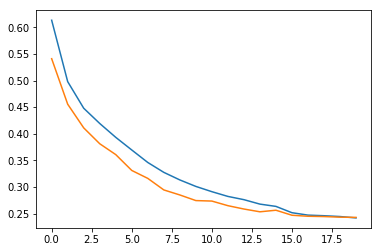

In [20]:
print (hist.history)
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])

## Load the model

In [19]:
from keras.models import load_model
model = load_model('my_model3.h5')

## predict the test data

In [21]:
y_pred = model.predict([X1_test, X2_test], batch_size=1024)

In [22]:
# To make a submission file 
def make_submission(predict_prob):
    with open('sub3.csv', 'w') as file:
        file.write(str('y_pre') + '\n')
        for line in predict_prob:
            #line = np.clip(line, 0.005, 0.995)
            file.write(str(line[0]) + '\n')
    file.close()
    
make_submission(y_pred)